# HAZARD HACKATHON CHALLANGE: ENERGY PRODUCTION
### This notebook is designed to show examples of handling nextgems data to obtain wind capacity factors at 100 m
#### Some subroutine were obtained from the training material for the Next Generation Challenges in Energy-Climate Modelling Workshop and atlite tool

<div class="alert alert-warning">
<b>Main question/goals of the challange:
<p>
<b> How good the NextGEMS models simulate wind?
<br>    
<b>How much the wind energy production will change in the near and far future for a specific country?
<br>
<b> What is the potential for hybrid energy generation?
<br>
<b> What about the extremes, do they become more frequent?
</p>
</div>

Let's Install enviroment from Flo, in the terminal of here in the notebook:

In [8]:
#!module use /work/k20200/k202134/hsm-tools/outtake/module 
#!module add python3/python_3.12-flo
#!install_kernel
## you may also need the following package:
#%pip install regionmask

Loading modules

In [39]:
import healpy as hp
import numpy as np
import intake ### nextgems catalog (at least for c3)
import pandas as pd
import cfgrib
import xarray as xr # xarray library access and manipulate multi-dimensional data (such as netcdf). With the cfgrib engine we can manipulate grib files
import regionmask # regionmask helps create of geographical regions.
from matplotlib import pyplot as plt # matplotlib package provides different functions to plot data
import re

## Example for ICON C4

Let's define some subroutines

In [66]:
def extrapolate_wind_speed(ds, to_height, from_height=None):
    """
    This suborutine is similar to atlite tool
    Extrapolate the wind speed from a given height above ground to another.

    If ds already contains a key refering to wind speeds at the desired to_height,
    no conversion is done and the wind speeds are directly returned.

    Extrapolation of the wind speed follows the logarithmic law as desribed in [1].

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset containing the wind speed time-series at 'from_height' with key
        'wnd{height:d}m' and the surface orography with key 'roughness' at the
        geographic locations of the wind speeds.
    from_height : int
        (Optional)
        Height (m) from which the wind speeds are interpolated to 'to_height'.
        If not provided, the closest height to 'to_height' is selected.
    to_height : int|float
        Height (m) to which the wind speeds are extrapolated to.

    Returns
    -------
    da : xarray.DataArray
        DataArray containing the extrapolated wind speeds. Name of the DataArray
        is 'wnd{to_height:d}'.

    References
    ----------
    [1] Equation (2) in Andresen, G. et al (2015): 'Validation of Danish wind
    time series from a new global renewable energy atlas for energy system
    analysis'.

    [2] https://en.wikipedia.org/w/index.php?title=Roughness_length&oldid=862127433,
    Retrieved 2019-02-15.
    """
    # Fast lane
    to_name = "wnd{h:0d}m".format(h=int(to_height))
    if to_name in ds:
        return ds[to_name]

    if from_height is None:
        # Determine closest height to to_name
        heights = np.asarray([int(s[3:-1]) for s in ds if re.match(r"wnd\d+m", s)])

        if len(heights) == 0:
            raise AssertionError("Wind speed is not in dataset")

        from_height = heights[np.argmin(np.abs(heights - to_height))]

    from_name = "wnd{h:0d}m".format(h=int(from_height))

    # Wind speed extrapolation
    wnd_spd = ds[from_name] * (
        np.log(to_height / ds["roughness"]) / np.log(from_height / ds["roughness"])
    )

    wnd_spd.attrs.update(
        {
            "long name": "extrapolated {ht} m wind speed using logarithmic "
            "method with roughness and {hf} m wind speed"
            "".format(ht=to_height, hf=from_height),
            "units": "m s**-1",
        }
    )

    return wnd_spd.rename(to_name)
    

def convert_to_windpower(wind_speed_data,power_curve_data):
    '''
    To convert from wind speed to wind power a function is defined below. 
    This interpolates the wind speeds from the curve onto a very fine resolution (501 points) 
    and then uses the numpy digitise function https://numpy.org/doc/stable/reference/generated/numpy.digitize.html 
    to assign each wind speed to a given capacity factor.
    '''
    
    # convert to an array
    power_curve_w = np.array(power_curve_data['ws'])
    power_curve_p = np.array(power_curve_data['cf'])

    #interpolate to fine resolution.
    pc_winds = np.linspace(0,50,501) # make it finer resolution
    pc_power = np.interp(pc_winds,power_curve_w,power_curve_p)

    reshaped_speed = wind_speed_data.flatten()
    test = np.digitize(reshaped_speed,pc_winds,right=False) # indexing starts
    #from 1 so needs -1: 0 in the next bit to start from the lowest bin.
    test[test ==len(pc_winds)] = 500 # make sure the bins don't go off the
    #end (power is zero by then anyway)
    wind_power_flattened = 0.5*(pc_power[test-1]+pc_power[test])

    wind_power_cf = np.reshape(wind_power_flattened,(np.shape(wind_speed_data)))

    return(wind_power_cf)

## Subroutine to get points
def get_nn_lon_lat_index(nside, lons, lats):
    
    lons2, lats2 = np.meshgrid(lons, lats)

    data = xr.DataArray(
        hp.ang2pix(ds.crs.healpix_nside, *np.meshgrid(lons, lats), nest=True, lonlat=True),
        coords=(("lat", lats), ("lon", lons)),
    )

    return data

Load main catalog

In [41]:
#Load data
cat = intake.open_catalog("https://nextgems.github.io/catalog/catalog.yaml")

Customize experiment, region and time period of 

refer to the data output for more details:

https://swift.dkrz.de/v1/dkrz_b381d76e-63d7-4aeb-96f0-dfd91e102d40/nextgems_prefinal/nextgems_prefinal_output.html


In [46]:
### zoom (from 1 to 9): use zoom 9 for higher resolution, if you want to rescale to 0.5, 1.0 degree use zoom =>7
## temporal resolution= 1H (from PT15M), 3H (from PT3H), 1D (from P1D)
## tested experiment [ngc4008]

### Select experiment and period
version='ngc4008'
datum0="2020-01-01"
datum="2020-01-31"

###Definition of your region of interest.
latbox = [15, 33]
lonbox = [-118, -86]
### Global domain
#latbox = [-90, 90]
#lonbox = [-180, 179]

### resolution and zoom level
dx=0.1 #0.1,0.25,1
dy=0.1 #0.1,0.25,1
zoom = 9 ## zoom 9 = 10km, zoom 7 = 50 km

#Variable selection, surface wind speed is available in ngc4008, so we load this
var= 'sfcwind'

### lat/lon vectors
loni = np.arange(lonbox[0], lonbox[1]+dx, dx)
lati = np.arange(latbox[0], latbox[1]+dy, dy)

In [47]:
### we extract the data let's take the highest temporal resolution
ds = cat.ICON[version](zoom=zoom,time="PT15M",chunks={}).to_dask().sel(time=slice(datum0, datum))

### resemple 1 hour 
da_healpix=ds[var].resample(time="1h").mean()

### we regrid the data
idx = get_nn_lon_lat_index(ds, loni, lati)

#Regridding
da_lonlat_array = np.reshape(da_healpix.isel(cell=idx).values,newshape=(len(da_healpix.time),len(lati),len(loni)))


##Transforming back to Data Array and adding original attributes
coords = {'time': da_healpix.time,
          'latitude': lati,
          'longitude': loni}
dims = ('time', 'latitude', 'longitude')
da_lonlat = xr.DataArray(da_lonlat_array, coords=coords, dims=dims, name=var)
da_lonlat.attrs.update(ds[var].attrs)

### to dataset
d = da_lonlat.to_dataset(name='wnd10m') 

### In this part you save the dataset as netcdf to future analysis
## d.to_netcdf('your_path/country_cfr_year_month.nc')

/home/k/k202134/python-envs/py_312/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


quick plot

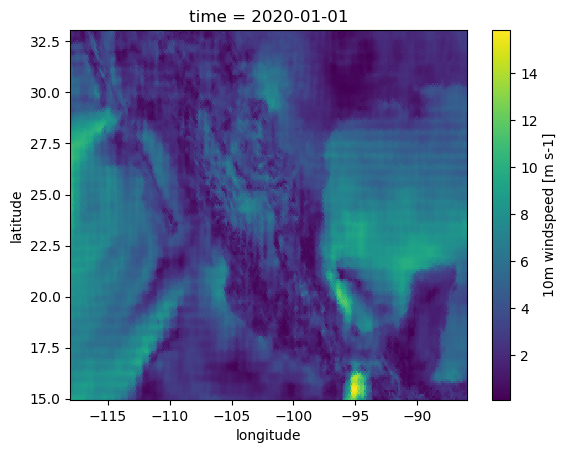

In [48]:
d['wnd10m'][0,...].plot()
#import cartopy.crs as ccrs
#fig = plt.figure(figsize=(10, 4))
#ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())
#ax.coastlines()
#ax.set_global()
#d['wnd10m'][0,...].plot(ax=ax,transform=ccrs.PlateCarree())

Extrapolate wind from 10 m to 100 m
We need to download ERA5 roughness since not present in the dataset
You can use following script

In [51]:
#d.longitude.max().values
#d.longitude.min().values
#d.latitude.max().values
#d.latitude.min().values
y1,y2 = latbox
x1,x2 = lonbox
'''
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'format': 'netcdf',
        'product_type': 'monthly_averaged_reanalysis',
        'variable': 'forecast_surface_roughness',
        'year': '2020',
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
########## y2, x1, y1, x2
        'area': [
            y2, x1, y1,x2,
        ],
        'time': '00:00',
    },
    'roughness.nc')
'''
#print(x1,x2,y1,y2)

"\nimport cdsapi\n\nc = cdsapi.Client()\n\nc.retrieve(\n    'reanalysis-era5-single-levels-monthly-means',\n    {\n        'format': 'netcdf',\n        'product_type': 'monthly_averaged_reanalysis',\n        'variable': 'forecast_surface_roughness',\n        'year': '2020',\n        'month': [\n            '01', '02', '03',\n            '04', '05', '06',\n            '07', '08', '09',\n            '10', '11', '12',\n        ],\n########## y2, x1, y1, x2\n        'area': [\n            y2, x1, y1,x2,\n        ],\n        'time': '00:00',\n    },\n    'roughness.nc')\n"

Add roughness to the wind array

In [53]:
### 
roughness = xr.open_dataset('roughness.nc')

roughness = roughness.rename({'fsr':'roughness'})

roughness = roughness.mean(dim='date')

### interpolate roughness
da = roughness.roughness.interp_like(d['wnd10m'].isel(time=0))

### add to the wind dataset
d=d.assign(roughness=da)

### extrapolate wind
to_height=100
wnd=extrapolate_wind_speed(d, to_height)

### quick plot
#wnd[0,...].plot()

Conversion to wind power

Run the following two blocks of code to load and plot the wind turbine power curve.

Note that knowledge of the names of the two fields wind speed 'ws' and capacity factor 'cf' were needed in advance. 
You can see these in the printed header of the file

    ws      cf
0  0.0  0  0.0
1  0.5  0  0.0
2  1.0  0  0.0
3  1.5  0  0.0
4  2.0  0  0.0


/tmp/ipykernel_591312/1746305178.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  cv = pd.read_csv('Vestas_v110_2000MW_ECEM_turbine.csv', names = ['ws', '', 'cf'], delimiter= '  ')


Text(0, 0.5, 'Capacity factor')

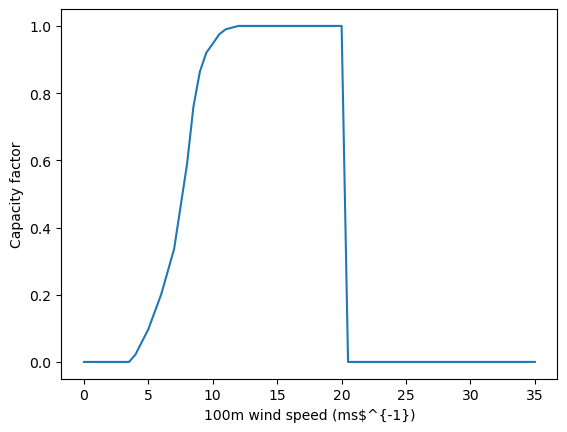

In [57]:
cv = pd.read_csv('Vestas_v110_2000MW_ECEM_turbine.csv', names = ['ws', '', 'cf'], delimiter= '  ')
print(cv.head())
plt.plot(cv['ws'],cv['cf'])
plt.xlabel('100m wind speed (ms$^{-1})')
plt.ylabel('Capacity factor')

Above we see that this turbine starts generating if hub-height winds are > 3 m/s and then has a 'ramping region' until around 11 m/s. 
The hub then reaches rated power and produces the same amount of generation for all wind speeds until the cut-out threshold.

Note that this curve represents an individual wind farm and does not try to model the interactions between wind turbines (due to turbulent wakes etc.) 
It also does not account for any foreced outages or efficiency reductions.

In [64]:
#Run the line of code below to convert the wind speed data into capacity factors. 
#Note this is a two step process which is both:
#passing ws100 through the wind power function and then creating a new field callled 'cf' in the data file.
d['cf'] = (['time', 'latitude', 'longitude'],  convert_to_windpower(wnd.values, cv) )
### In this part you save the dataset as netcdf to future analysis
## d.to_netcdf('your_path/country_cfr_year_month.nc')

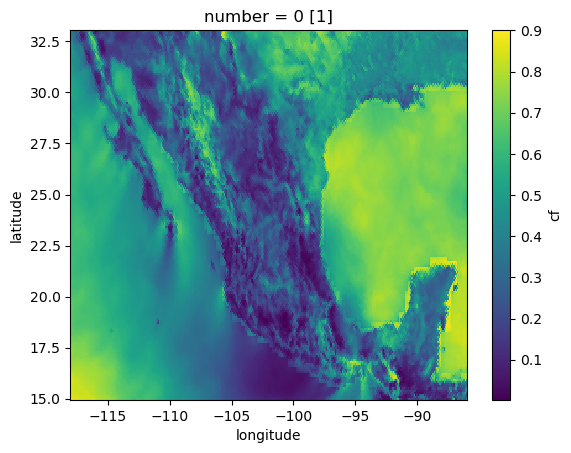

In [65]:
##Now we can plot the mean capacity factor por the selected period
d['cf'].mean(axis=0).plot()

We can aggregate a raster (in this example, wind speed gridded data) using a vector file (shapefile) of administrative border.
There are many ways to perform this task, here we use the package regionmask


In [61]:
# create the cosine weight of latitudes
weigths = np.cos(np.deg2rad(d.latitude))
# create mask of countries based on the data latitude and longitude
countries_masked = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask(d, lon_name='longitude', lat_name='latitude')

/home/b/b382006/.local/lib/python3.12/site-packages/regionmask/core/mask.py:179: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(


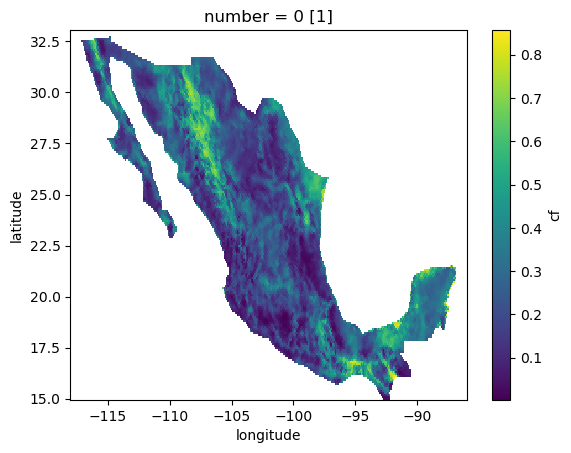

In [62]:
### select variable to mask and plot mean
tmp =d['cf'].where(countries_masked==regionmask.defined_regions.natural_earth_v5_0_0.countries_110.map_keys(['Mexico']))
tmp.mean(axis=0).plot() 

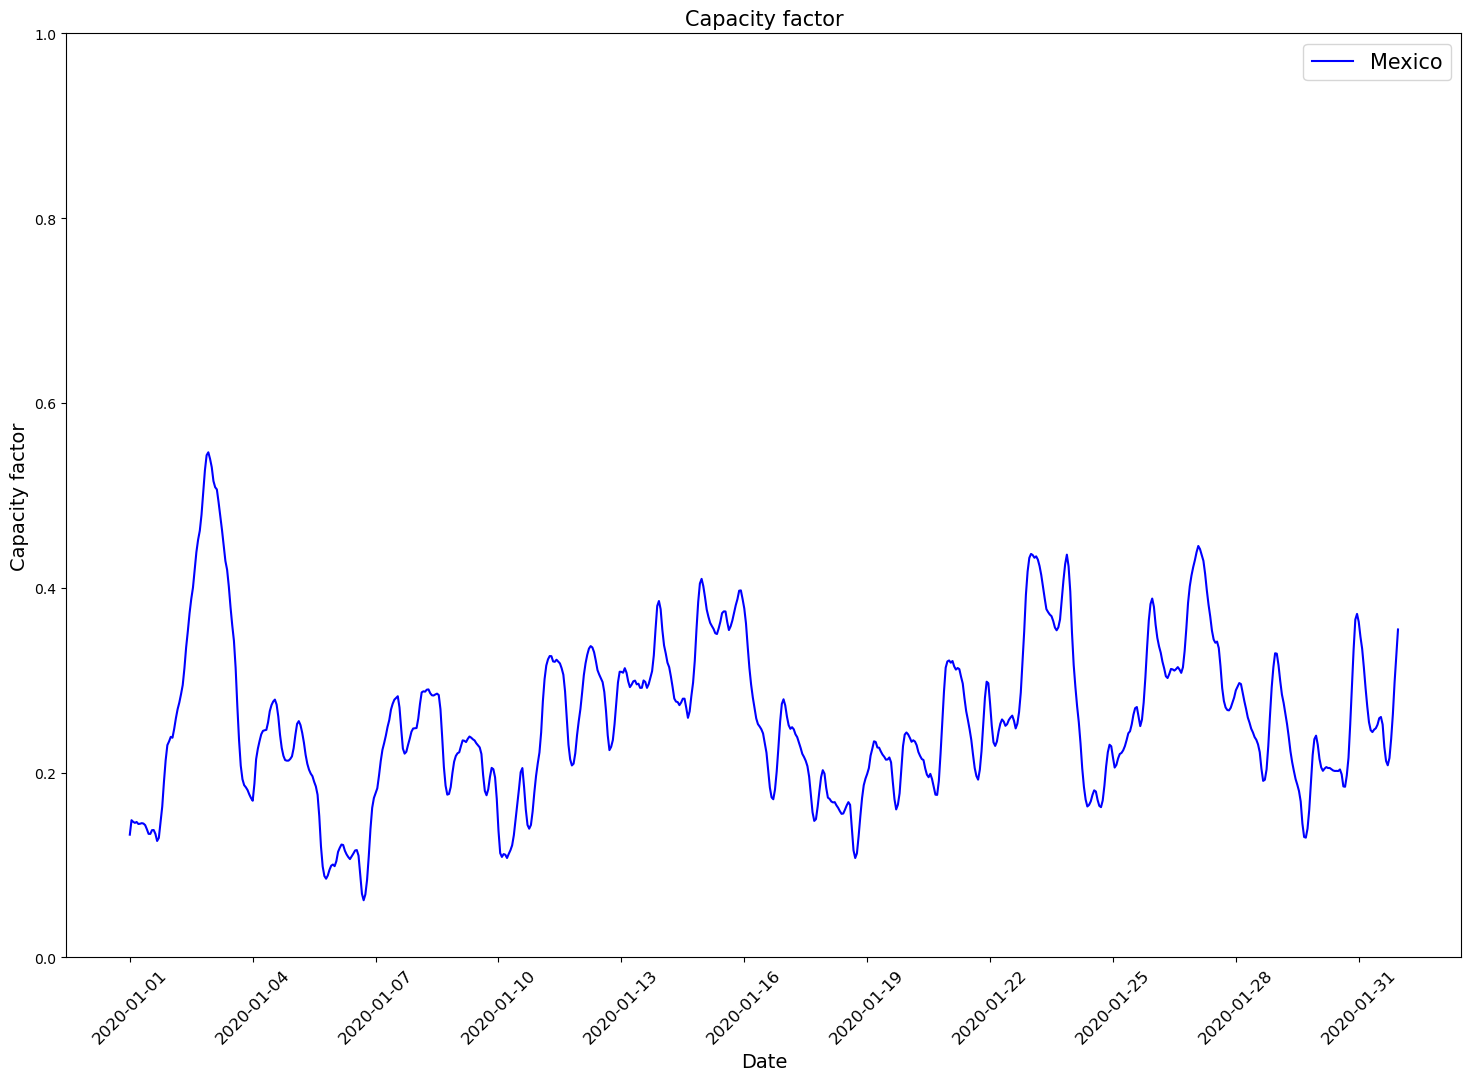

In [63]:
### we can plot the time serie of the averaged region
countries_name ='Mexico'# ['Spain', 'Spain', 'Spain']
colors ='blue'# ['blue', 'green', 'orange']
fig, ax = plt.subplots(figsize=(18, 12))

# select different countries
#    ds_country =d['ws100'].where(countries_masked==regionmask.defined_regions.natural_earth_v5_0_0.countries_110.map_keys(i))
ds_country =d['cf'].where(countries_masked==regionmask.defined_regions.natural_earth_v5_0_0.countries_110.map_keys(countries_name))
# applied the weighted mean over the country
wnd100m_country = ds_country.weighted(weigths).mean(dim=('latitude', 'longitude'))
ax.plot(wnd100m_country, color=colors, label=countries_name)
ax.set_xticks(np.arange(0, len(wnd100m_country.time), 3 * 24))
ax.set_xticklabels(wnd100m_country['time'].values[0: -1: 3 * 24].astype('datetime64[D]'), rotation=45, fontsize=12)
#ax.set_ylim([0, 18])
ax.set_ylim([0, 1])
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Capacity factor', fontsize=14)
ax.legend(fontsize=15)
plt.title('Capacity factor', fontsize=15)
plt.savefig('icon_spain_cfr.png')

## Example IFS

Let's define some subroutines

In [74]:
def convert_to_windpower(wind_speed_data,power_curve_data):
    # convert to an array
    power_curve_w = np.array(power_curve_data['ws'])
    power_curve_p = np.array(power_curve_data['cf'])

    #interpolate to fine resolution.
    pc_winds = np.linspace(0,50,501) # make it finer resolution
    pc_power = np.interp(pc_winds,power_curve_w,power_curve_p)

    reshaped_speed = wind_speed_data.flatten()
    test = np.digitize(reshaped_speed,pc_winds,right=False) # indexing starts
    #from 1 so needs -1: 0 in the next bit to start from the lowest bin.
    test[test ==len(pc_winds)] = 500 # make sure the bins don't go off the
    #end (power is zero by then anyway)
    wind_power_flattened = 0.5*(pc_power[test-1]+pc_power[test])

    wind_power_cf = np.reshape(wind_power_flattened,(np.shape(wind_speed_data)))

    return(wind_power_cf)
    
### 2D variables
def get_nn_lon_lat_index(nside, lons, lats):
    
    lons2, lats2 = np.meshgrid(lons, lats)
    data = xr.DataArray(hp.ang2pix(nside, lons2, lats2, nest=True, lonlat=True),
                        coords=[("lat", lats), ("lon", lons)],)

    return data

Let's load the catalog and configure the experiment, region and resolution

In [69]:
#Load data catalog
cat = intake.open_catalog("https://nextgems.github.io/catalog/catalog.yaml")

####
### Select experiment and period
###version='IFS_9-FESOM_5-production-hist'
version='IFS_9-FESOM_5-production'
###product = '2D_hourly_healpix128_winds100m' ## this contains winds at 100m (*128*, zoom = 7 = 50 km)
product='2D_hourly_healpix512_winds100m' ## this contains winds at 100m (*512*, zoom = 9 = 10 km)
t0="2020-01-01"
t1="2020-01-31"
zoom = 9 #### zoom (only zoom 9~12km and 7~48 km) Modify this depending on the prodcut!!!!
#Definition of your region of interest.
latbox = [15, 33]
lonbox = [-118, -86]

#Variable selection, we will load
var = '100u'
var2='100v'

### resolution, this similar to ERA5
dx=0.1#0.1,0.25,1
dy=0.1#0.1,0.25,1

### lat/lon vectors
lon = np.arange(lonbox[0], lonbox[1]+dx, dx)
lat = np.arange(latbox[0], latbox[1]+dy, dy)

ds = cat.IFS[version][product].to_dask().drop_duplicates('time', keep='last')

idx = get_nn_lon_lat_index(2**zoom, lon, lat)

da_healpix = ds[var].sel(time=slice(t0,t1))
da_healpix2 = ds[var2].sel(time=slice(t0,t1))


#Regridding
da_healpix_array = da_healpix.values
da_healpix_array2 = da_healpix2.values

da_lonlat_array = da_healpix_array[:,idx]
da_lonlat_array2 = da_healpix_array2[:,idx]

#Transforming back to Data Array and adding original attributes
coords = {'time': da_healpix.time,
          'latitude': lat,
          'longitude': lon}
dims = ('time', 'latitude', 'longitude')
da_lonlat = xr.DataArray(da_lonlat_array, coords=coords, dims=dims, name=var)
da_lonlat.attrs.update(ds[var].attrs)
###da_lonlat.attrs.update(ds.attrs)
da_lonlat2 = xr.DataArray(da_lonlat_array2, coords=coords, dims=dims, name=var2)
da_lonlat2.attrs.update(ds[var2].attrs)

#Quick plot see the results (first time step)
#plt.imshow(np.flip(da_lonlat[0,:,:],axis=0))

/home/k/k202134/python-envs/py_312/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [70]:
### compute wind speed and convert to dataset

In [71]:
wnd100m = (da_lonlat**2 + da_lonlat2**2)**(1/2)
### we convert it to dataset and update atributes
d = wnd100m.to_dataset(name='wnd100m')
d.wnd100m.attrs['units'] = 'm s**-1'

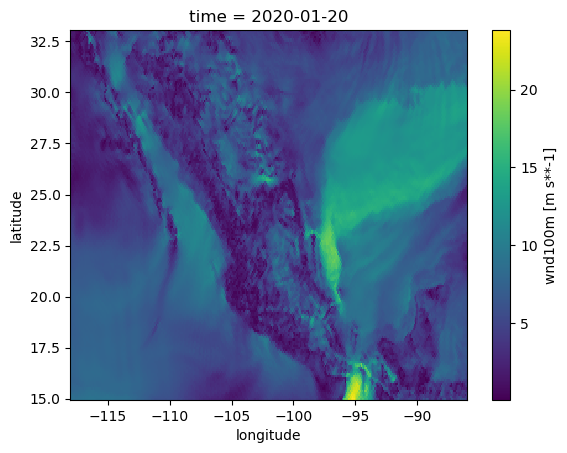

In [72]:
### quick plot
d['wnd100m'][0,...].plot()  

In [75]:
###Conversion to wind power

    ws      cf
0  0.0  0  0.0
1  0.5  0  0.0
2  1.0  0  0.0
3  1.5  0  0.0
4  2.0  0  0.0


/tmp/ipykernel_591312/1746305178.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  cv = pd.read_csv('Vestas_v110_2000MW_ECEM_turbine.csv', names = ['ws', '', 'cf'], delimiter= '  ')


Text(0, 0.5, 'Capacity factor')

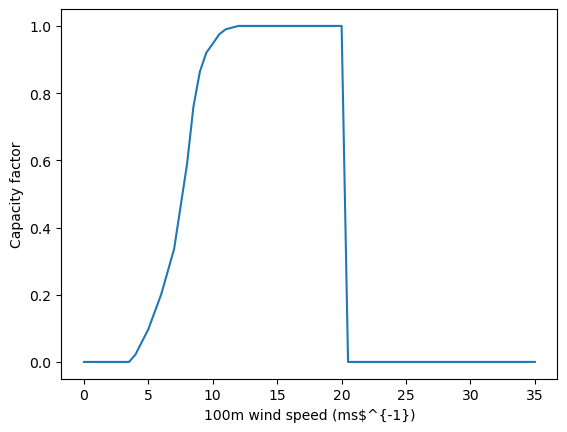

In [76]:
cv = pd.read_csv('Vestas_v110_2000MW_ECEM_turbine.csv', names = ['ws', '', 'cf'], delimiter= '  ')
print(cv.head())
plt.plot(cv['ws'],cv['cf'])
plt.xlabel('100m wind speed (ms$^{-1})')
plt.ylabel('Capacity factor')

Above we see that this turbine starts generating if hub-height winds are > 3 m/s and then has a 'ramping region' until around 11 m/s. 
The hub then reaches rated power and produces the same amount of generation for all wind speeds until the cut-out threshold.

Note that this curve represents an individual wind farm and does not try to model the interactions between wind turbines (due to turbulent wakes etc.) 
It also does not account for any foreced outages or efficiency reductions.

In [77]:
d['cf'] = (['time', 'latitude', 'longitude'],  convert_to_windpower(d['wnd100m'].values, cv) )
### In this part you save the dataset as netcdf to future analysis
## d.to_netcdf('your_path/country_cfr_year_month.nc'

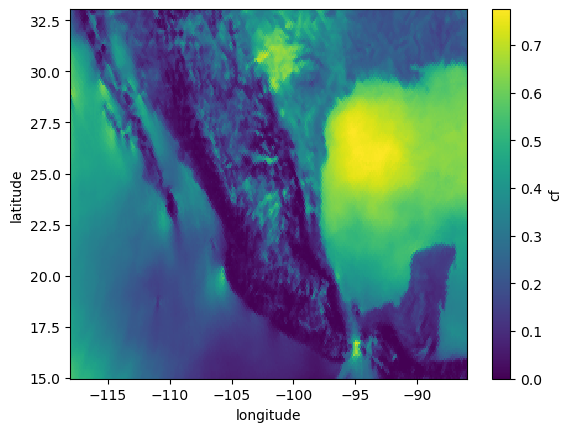

In [78]:
#d['cf'].isel(time=slice(0,48, 8)).plot(x="longitude", y="latitude", col="time", col_wrap=3, cmap=plt.cm.viridis)
d['cf'].mean(axis=0).plot()
### In this part you save the dataset as netcdf to future analysis
## d.to_netcdf('your_path/country_cfr_year_month.nc')

We can aggregate a raster (in this example, wind speed gridded data) using a vector file (shapefile) of administrative border.
There are many ways to perform this task, here we use the package regionmask

In [83]:
# create the cosine weight of latitudes
weigths = np.cos(np.deg2rad(d.latitude))
# create mask of countries based on the data latitude and longitude
countries_masked = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask(d, lon_name='longitude', lat_name='latitude')

/home/b/b382006/.local/lib/python3.12/site-packages/regionmask/core/mask.py:179: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(


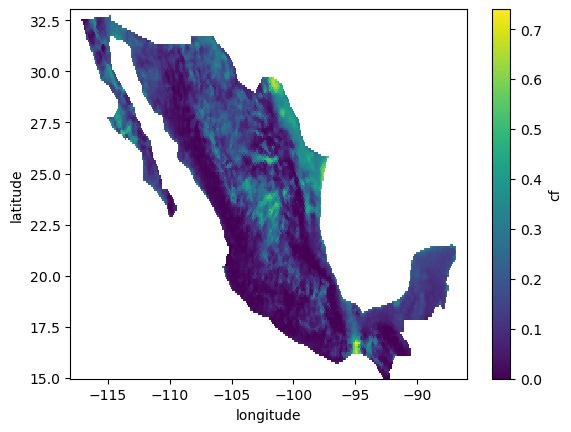

In [84]:
## how to apply a mask (country mask, weighted mask)
### select variable to mask and plot mean
tmp =d['cf'].where(countries_masked==regionmask.defined_regions.natural_earth_v5_0_0.countries_110.map_keys(['Mexico']))
tmp.mean(axis=0).plot()                          

In [85]:
### you can also aggreate daily, monthly
#d_daily=d.resample(time='D').mean()
#d_daily

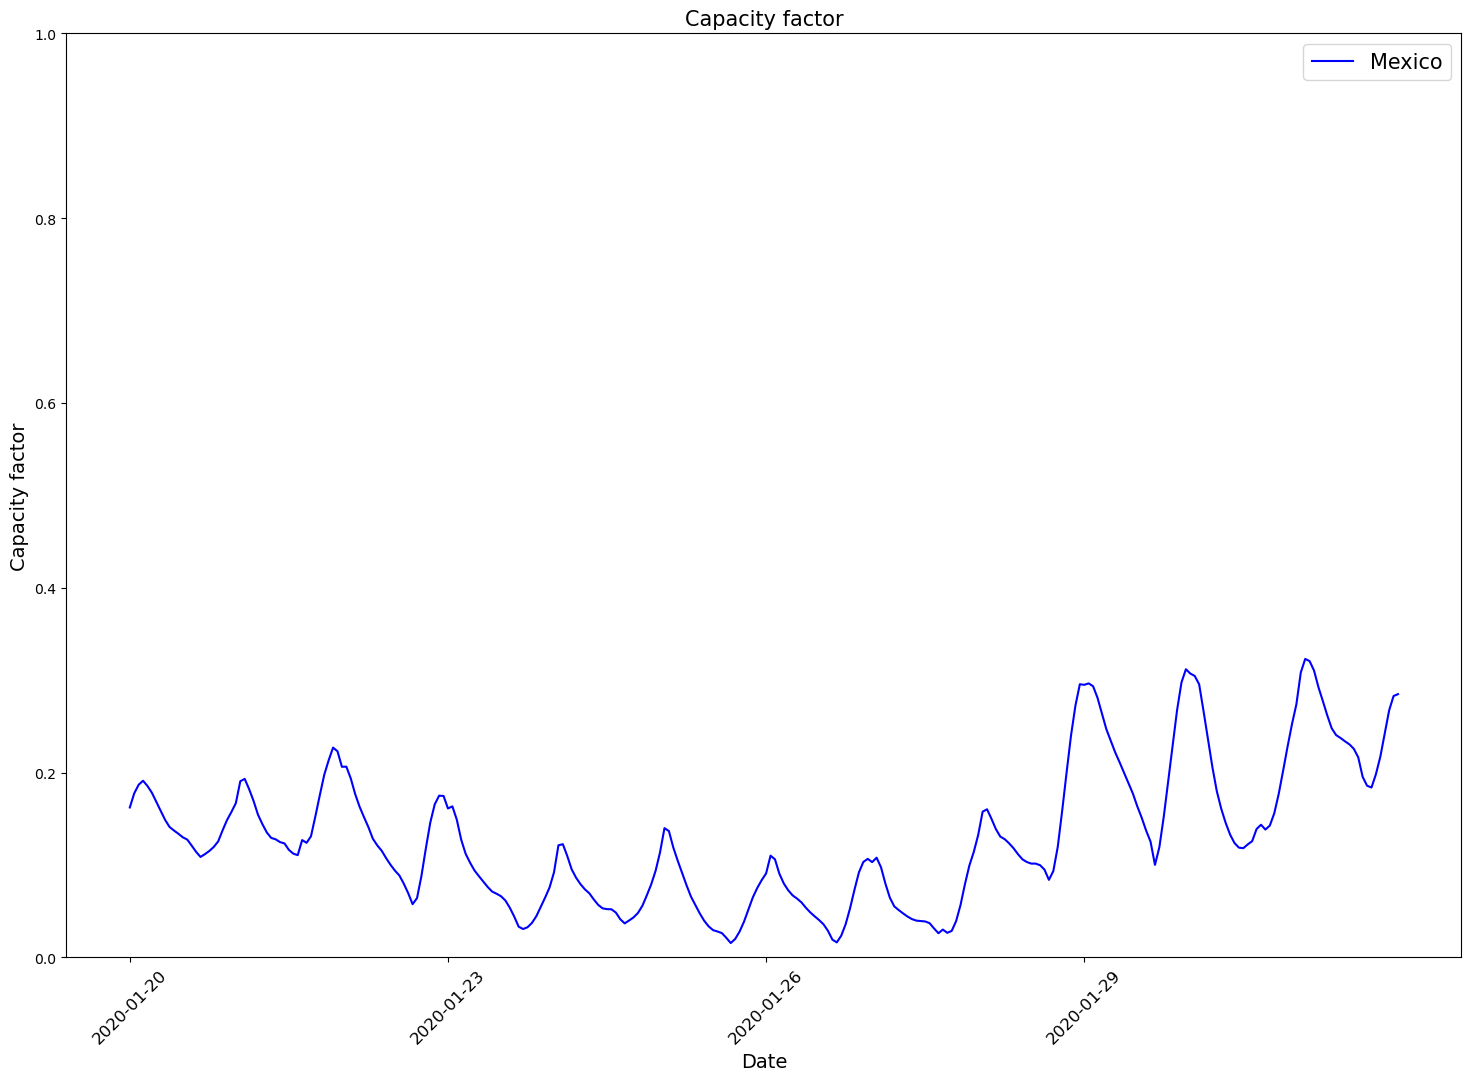

In [86]:
### we can plot the time serie of the averaged region
countries_name ='Mexico'# ['Spain', 'Spain', 'Spain']
colors ='blue'# ['blue', 'green', 'orange']
fig, ax = plt.subplots(figsize=(18, 12))

# select different countries
#    ds_country =d['ws100'].where(countries_masked==regionmask.defined_regions.natural_earth_v5_0_0.countries_110.map_keys(i))
ds_country =d['cf'].where(countries_masked==regionmask.defined_regions.natural_earth_v5_0_0.countries_110.map_keys(countries_name))
# applied the weighted mean over the country
wnd100m_country = ds_country.weighted(weigths).mean(dim=('latitude', 'longitude'))
ax.plot(wnd100m_country, color=colors, label=countries_name)
ax.set_xticks(np.arange(0, len(wnd100m_country.time), 3 * 24))
ax.set_xticklabels(wnd100m_country['time'].values[0: -1: 3 * 24].astype('datetime64[D]'), rotation=45, fontsize=12)
#ax.set_ylim([0, 18])
ax.set_ylim([0, 1])
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Capacity factor', fontsize=14)
ax.legend(fontsize=15)
plt.title('Capacity factor', fontsize=15)
plt.savefig('ifs_spain_cfr.png')

## What about observations

Some plataforms are
https://tealtool.earth

wind atlas
https://globalwindatlas.info/en

In [87]:
### Here some observational datasets 

In [89]:
## To download files from google
#%pip install gdown
#import gdown

In [90]:
## wind capacity factor EUROPE
#url='https://drive.google.com/uc?id=1FpsIuZOCV6Pnk5wbgWxVzm_t-BK_p7KU'
#output='ERA5_wind_power_capacity_factor_all_countries_2000_2019_inclusive.parquet'
#gdown.download(url, output)

# read parquet file (adapt path)
#era5_wind_cfr = pd.read_parquet("ERA5_wind_power_capacity_factor_all_countries_2000_2019_inclusive.parquet")
#era5_wind_cfr['Germany'].plot()

In [91]:
#ENTSO-E Transparency Platform EUROPE
#url='https://drive.google.com/uc?id=1opsm5QD6TSR9cICoYh9F8GlKi3umBQeM'
#output='ENTSOE-TP-wind-20200201-20200229.parquet'
#gdown.download(url, output)

# read parquet file (adapt path)
#entso_wind_cfr = pd.read_parquet("ENTSOE-TP-wind-20200201-20200229.parquet")
#entso_wind_cfr

In [92]:
#ERA 5
#https://cds.climate.copernicus.eu/datasets/sis-energy-derived-reanalysis?tab=download

In [93]:
### Lidar data USA
#https://oswbuoysny.resourcepanorama.dnv.com

In [94]:
### global offshore platform
#https://www.4coffshore.com/windfarms/

In [95]:
## USA wind turbine dataset
#https://eerscmap.usgs.gov/uswtdb/viewer/#3.15/37.25/-96.25